In [46]:
import pandas as pd

df = pd.read_csv('./all/train.csv', nrows=100000)
mean_fare = df['fare_amount'].mean()
min = df['fare_amount'].min()
print('Min before cleaning:', min)
df['fare_amount'] = df['fare_amount'].apply(lambda x: mean_fare if x < 0 else x)
min = df['fare_amount'].min()
print('Min after cleaning:', min)

df[df['fare_amount']==0.0]

Min before cleaning: -44.9
Min after cleaning: 0.0


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
10002,2010-02-15 14:26:01.0000003,0.0,2010-02-15 14:26:01 UTC,-73.987115,40.738808,-74.005911,40.713960,1
27891,2015-05-15 21:40:28.00000010,0.0,2015-05-15 21:40:28 UTC,-74.077927,40.805714,-74.077919,40.805721,1
47302,2010-03-18 19:13:39.0000002,0.0,2010-03-18 19:13:39 UTC,-73.942346,40.806269,-73.942463,40.806129,1


In [23]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


In [25]:
df.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,0.008975,-0.008952,0.006322,-0.005587,0.015804
pickup_longitude,0.008975,1.000000,-0.946674,0.937559,-0.911016,-0.001342
pickup_latitude,-0.008952,-0.946674,1.000000,-0.926534,0.930183,-0.000920
dropoff_longitude,0.006322,0.937559,-0.926534,1.000000,-0.963604,-0.000380
dropoff_latitude,-0.005587,-0.911016,0.930183,-0.963604,1.000000,-0.002173
passenger_count,0.015804,-0.001342,-0.000920,-0.000380,-0.002173,1.000000


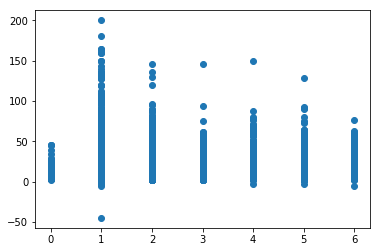

In [28]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.scatter(df['passenger_count'], df['fare_amount'])

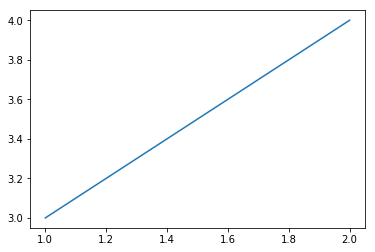

In [30]:
x = [1,2]
y = [3,4]
plt.plot(x, y)